<a href="https://colab.research.google.com/github/diegohugo570/backup-python/blob/main/01_Human_In_The_Loop_Encontro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langgraph langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.3 MB/s eta 0:00:00


In [ ]:
from typing import TypedDict, Literal
import uuid

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from IPython.display import Image, display


In [ ]:
class State(TypedDict):
  feedback: str
  acao: Literal["aprovo", "reprovo"]
  texto_inicial: str

In [ ]:
def node_1(state: State) -> State:
  print("--- Passou pelo nó 1 ----")
  return {"texto_inicial": "olá, tudo bem?"}

def human_in_the_loop(state: State) -> Command[Literal["node_2", "node_3"]]:
  resume_human_feedback = interrupt({"pergunta": "Você aprova ou reprova?",
                        "texto_revisado": state["texto_inicial"]})

  acao = resume_human_feedback["acao"]
  feedback = resume_human_feedback.get("feedback")

  if acao == "aprovo":
    return Command(goto = "node_2")
  else:
    return Command(goto = "node_3", update = {"feedback": feedback})

def node_2(state: State) -> State:
  print("--- Passou pelo nó 2 ----")
  return state

def node_3(state: State) -> State:
  print("--- Passou pelo nó 3 ----")
  feedback = state["feedback"]

  resposta = llm.invoke("Corrija ot exto abaixo com o feedback do usuariuo: {feedback}")
  return state

In [ ]:
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("human_in_the_loop", human_in_the_loop)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.set_entry_point("node_1")
builder.add_edge("node_1", "human_in_the_loop")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer = checkpointer)

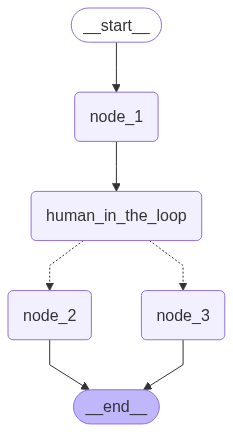

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": uuid.uuid4()}}

In [ ]:
result = graph.invoke({}, config = config)
result

--- Passou pelo nó 1 ----


{'texto_inicial': 'olá, tudo bem?',
 '__interrupt__': [Interrupt(value={'pergunta': 'Você aprova ou reprova?', 'texto_revisado': 'olá, tudo bem?'}, resumable=True, ns=['human_in_the_loop:41e928e2-9fb8-1cfa-83bb-a3923f6b3a1f'])]}

In [ ]:
result["__interrupt__"][0].value

{'pergunta': 'Você aprova ou reprova?', 'texto_revisado': 'olá, tudo bem?'}

In [ ]:
graph.get_state(config)

StateSnapshot(values={'texto_inicial': 'olá, tudo bem?'}, next=('human_in_the_loop',), config={'configurable': {'thread_id': 'a07c7d33-ad76-4c41-9864-82a3290300c1', 'checkpoint_ns': '', 'checkpoint_id': '1f04e263-2ee0-61df-8001-64c5d327c969'}}, metadata={'source': 'loop', 'writes': {'node_1': {'texto_inicial': 'olá, tudo bem?'}}, 'step': 1, 'parents': {}, 'thread_id': 'a07c7d33-ad76-4c41-9864-82a3290300c1'}, created_at='2025-06-20T22:30:41.866779+00:00', parent_config={'configurable': {'thread_id': 'a07c7d33-ad76-4c41-9864-82a3290300c1', 'checkpoint_ns': '', 'checkpoint_id': '1f04e263-2edd-61c1-8000-af3d22491471'}}, tasks=(PregelTask(id='41e928e2-9fb8-1cfa-83bb-a3923f6b3a1f', name='human_in_the_loop', path=('__pregel_pull', 'human_in_the_loop'), error=None, interrupts=(Interrupt(value={'pergunta': 'Você aprova ou reprova?', 'texto_revisado': 'olá, tudo bem?'}, resumable=True, ns=['human_in_the_loop:41e928e2-9fb8-1cfa-83bb-a3923f6b3a1f']),), state=None, result=None),), interrupts=(Inter

In [ ]:
final_result = graph.invoke(Command(resume = {"acao": "reprovo", "feedback": "ta ruim demais"}), config = config)

--- Passou pelo nó 3 ----


In [ ]:
final_result

{'feedback': 'ta ruim demais', 'texto_inicial': 'olá, tudo bem?'}

# Human-in-the-loop (HITL) | Tool Calling

In [ ]:
from langchain_core.tools import tool

@tool
def pega_horario_atual(cidade: str) -> str:
  """
  Obtem o horario atual das cidades.
  """
  if cidade == "barueri, SP":
    return "8 da noite"

  elif cidade == "sao paulo, SP":
    return "9 da noite"

  else:
    return "meia noite"

In [ ]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4.1-mini", temperature = 0.2).bind_tools([pega_horario_atual])

In [ ]:
resposta_tool_call = llm.invoke("qual o horario atual de barueri?")

In [ ]:
from langgraph.graph import MessagesState

class State(MessagesState):
  """Estado de mensagens"""

In [ ]:
lista_teste = [1, 2, 3, 4]
lista_teste.append(5)
lista_teste

[1, 2, 3, 4, 5]

In [ ]:
def node_llm(state: State) -> State:
  return {"messages": [llm.invoke(state["messages"])]}

In [ ]:
resposta_tool_call.tool_calls[-1]

{'name': 'pega_horario_atual',
 'args': {'cidade': 'Barueri'},
 'id': 'call_NuL5mkIdlatUQqx3tmyHMJYm',
 'type': 'tool_call'}

In [ ]:
resposta_humano = {
    "acao": "aprovar|atualizar|feedback",
    "human_data": {'cidade': 'Barueri'}
}

In [ ]:
def human_in_the_loop(state: State) -> Command[Literal["node_llm", "run_tool"]]:

  ultima_mensagem = state["messages"][-1]
  chamada_funcao = ultima_mensagem.tool_calls[-1]

  resposta_humano = interrupt({
      "question": "Tá correto?",
      "tool_call": chamada_funcao
  })

  acao = resposta_humano["acao"]
  human_data = resposta_humano.get("human_data")

  if acao == "aprovar":
    return Command(goto = "run_tool")

  if acao == "atualizar":
    updated_tool_call = {
        "role": "ai",
        "content": ultima_mensagem.content,
        "tool_calls": [
            {
                "id": chamada_funcao["id"],
                "name": chamada_funcao["name"],
                "args": human_data
            }
        ],
        "id": ultima_mensagem.id
    }

    return Command(goto = "run_tool", update = {"messages": [updated_tool_call]})

  if acao == "feedback":
    tool_call = {
        "role": "tool",
        "content": human_data,
        "name": chamada_funcao["name"],
        "tool_call_id": chamada_funcao["id"]
    }

    return Command(goto = "node_llm", update = {"messages": [tool_call]})

In [ ]:
def run_tool(state: State) -> State:
    new_messages = []
    tools = {"pega_horario_atual": pega_horario_atual}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages}

In [ ]:
def need_tool_calling(state: State) -> Literal[END, "human_in_the_loop"]:
  ultima_mensagem = state["messages"][-1]
  if len(ultima_mensagem.tool_calls) == 0:
    return END

  return "human_in_the_loop"

In [ ]:
builder = StateGraph(State)

builder.add_node("node_llm", node_llm)
builder.add_node("run_tool", run_tool)
builder.add_node("human_in_the_loop", human_in_the_loop)

builder.add_edge(START, "node_llm")
builder.add_conditional_edges("node_llm", need_tool_calling)
builder.add_edge("run_tool", "node_llm")

memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

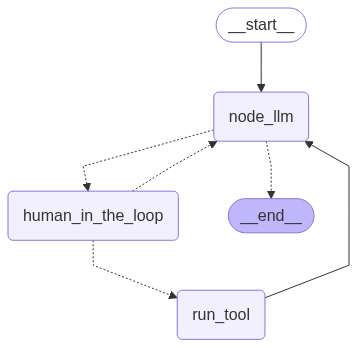

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": uuid.uuid4()}}
input_inicial = {"messages": [{'role': "user", "content": "opa, e ai?"}]}

for event in graph.stream(input_inicial, config, stream_mode="updates"):
    print(event)
    print("\n")

{'node_llm': {'messages': [AIMessage(content='Oi! Tudo bem por aqui, e com você? Como posso ajudar hoje?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 54, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkfFLXWR4smGnJ0KQwyVtSBfeXFmW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c8a0d97a-fe15-46ba-8996-3097011fe73c-0', usage_metadata={'input_tokens': 54, 'output_tokens': 17, 'total_tokens': 71, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}




## Aprovar

In [ ]:
def formata_human_in_the_loop(valor: dict) -> None:
  pergunta = valor["question"]
  argumentos = valor["tool_call"]["args"]
  nome_funcao = valor["tool_call"]["name"]

  print(pergunta)
  print(f"- Nome da função: {nome_funcao}\n- Arugmentos fornecidos pelo LLM: {argumentos}")

In [ ]:
config = {"configurable": {"thread_id": uuid.uuid4()}}
input_inicial = {"messages": [{'role': "user", "content": "qual eh o horario de barueri atualmente?"}]}

for event in graph.stream(input_inicial, config, stream_mode="updates"):
    print(event)
    print("\n")

{'node_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_t8GJKf8sHnDLcsqSaGUKCVno', 'function': {'arguments': '{"cidade":"Barueri"}', 'name': 'pega_horario_atual'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 59, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkfEk6zKaWFr6f7pUiDjUawlCUsr6', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4454bd3c-2156-48ef-9468-5d662fd5115e-0', tool_calls=[{'name': 'pega_horario_atual', 'args': {'cidade': 'Barueri'}, 'id': 'call_t8GJKf8sHnDLcsqSaGUKCVno', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'output_tokens': 21, '

In [ ]:
formata_human_in_the_loop(event["__interrupt__"][0].value)

Tá correto?
- Nome da função: pega_horario_atual
- Arugmentos fornecidos pelo LLM: {'cidade': 'Barueri'}


In [ ]:
for event in graph.stream(Command(resume = {"acao": "aprovar"}), config, stream_mode="updates"):
    print(event)
    print("\n")

{'human_in_the_loop': None}


{'run_tool': {'messages': [{'role': 'tool', 'name': 'pega_horario_atual', 'content': 'meia noite', 'tool_call_id': 'call_t8GJKf8sHnDLcsqSaGUKCVno'}]}}


{'node_llm': {'messages': [AIMessage(content='O horário atual em Barueri é meia-noite. Posso ajudar em mais alguma coisa?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 96, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkfElpwaesrUxJrZ6LkOj3z4Vc0ok', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--40a94278-2d89-43c7-b876-bccdce5efce7-0', usage_metadata={'input_tokens': 96, 'output_tokens': 21, 'total_tokens': 117, 'input_token_details'

## Atualizar

In [ ]:
config = {"configurable": {"thread_id": uuid.uuid4()}}
input_inicial = {"messages": [{'role': "user", "content": "qual eh o horario de barueri atualmente?"}]}

for event in graph.stream(input_inicial, config, stream_mode="updates"):
    print(event)
    print("\n")

{'node_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DXtsDTf94QPIZ9rZ8bySt0t4', 'function': {'arguments': '{"cidade":"Barueri"}', 'name': 'pega_horario_atual'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 59, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkfEmXGCLyDjhOpT8Mot6XInhcCnx', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d7aac227-4477-44f5-9992-bccba5b3c874-0', tool_calls=[{'name': 'pega_horario_atual', 'args': {'cidade': 'Barueri'}, 'id': 'call_DXtsDTf94QPIZ9rZ8bySt0t4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'output_tokens': 21, '

In [ ]:
formata_human_in_the_loop(event["__interrupt__"][0].value)

Tá correto?
- Nome da função: pega_horario_atual
- Arugmentos fornecidos pelo LLM: {'cidade': 'Barueri'}


In [ ]:
for event in graph.stream(Command(resume = {"acao": "atualizar", "human_data": {"cidade": "barueri, SP"}}), config, stream_mode="updates"):
    print(event)
    print("\n")

{'human_in_the_loop': {'messages': [{'role': 'ai', 'content': '', 'tool_calls': [{'id': 'call_DXtsDTf94QPIZ9rZ8bySt0t4', 'name': 'pega_horario_atual', 'args': {'cidade': 'barueri, SP'}}], 'id': 'run--d7aac227-4477-44f5-9992-bccba5b3c874-0'}]}}


{'run_tool': {'messages': [{'role': 'tool', 'name': 'pega_horario_atual', 'content': '8 da noite', 'tool_call_id': 'call_DXtsDTf94QPIZ9rZ8bySt0t4'}]}}


{'node_llm': {'messages': [AIMessage(content='O horário atual em Barueri é 8 da noite. Posso ajudar em mais alguma coisa?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 98, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkfEm6VohHafObxdRszBeXprzKwGx', 'ser

## Feedback

In [ ]:
config = {"configurable": {"thread_id": uuid.uuid4()}}
input_inicial = {"messages": [{'role': "user", "content": "qual eh o horario de barueri atualmente?"}]}

for event in graph.stream(input_inicial, config, stream_mode="updates"):
    print(event)
    print("\n")

{'node_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qc4yFNZl984ylobUZFThHgDu', 'function': {'arguments': '{"cidade":"Barueri"}', 'name': 'pega_horario_atual'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 59, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkfIRN6E6aQXhD4cH4DFWDiwGxO6j', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4f3cfc0c-9335-4ad4-a981-77d80d8cae3d-0', tool_calls=[{'name': 'pega_horario_atual', 'args': {'cidade': 'Barueri'}, 'id': 'call_qc4yFNZl984ylobUZFThHgDu', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'output_tokens': 21, '

In [ ]:
formata_human_in_the_loop(event["__interrupt__"][0].value)

Tá correto?
- Nome da função: pega_horario_atual
- Arugmentos fornecidos pelo LLM: {'cidade': 'Barueri'}


In [ ]:
for event in graph.stream(Command(resume = {"acao": "feedback", "human_data": "User request changes: mude o nome da cidade para minusculo e a sigla do estado (em maiusculo) em seguida de uma virgula <cidade, sigla>"}), config, stream_mode="updates"):
    print(event)
    print("\n")

{'human_in_the_loop': {'messages': [{'role': 'tool', 'content': 'User request changes: mude o nome da cidade para minusculo e a sigla do estado (em maiusculo) em seguida de uma virgula <cidade, sigla>', 'name': 'pega_horario_atual', 'tool_call_id': 'call_qc4yFNZl984ylobUZFThHgDu'}]}}


{'node_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rW7iv1rYXzCrIjs5mvDweBUh', 'function': {'arguments': '{"cidade":"barueri, SP"}', 'name': 'pega_horario_atual'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 130, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkfISCIF5SwxiphGE6y9f7nXXmR3h', 'service_tier': 'default', '

In [ ]:
formata_human_in_the_loop(event["__interrupt__"][0].value)

Tá correto?
- Nome da função: pega_horario_atual
- Arugmentos fornecidos pelo LLM: {'cidade': 'barueri, SP'}


In [ ]:
for event in graph.stream(Command(resume = {"acao": "aprovar"}), config, stream_mode="updates"):
    print(event)
    print("\n")

{'human_in_the_loop': None}


{'run_tool': {'messages': [{'role': 'tool', 'name': 'pega_horario_atual', 'content': '8 da noite', 'tool_call_id': 'call_rW7iv1rYXzCrIjs5mvDweBUh'}]}}


{'node_llm': {'messages': [AIMessage(content='O horário atual em Barueri, SP, é 8 da noite. Posso ajudar em mais alguma coisa?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 169, 'total_tokens': 194, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkfIiCftLcg67BEmjX1nfoC079Jc8', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a6dd16d3-a912-4d41-a9a1-c1ad5388af61-0', usage_metadata={'input_tokens': 169, 'output_tokens': 25, 'total_tokens': 194, 'input_token_d

In [ ]:
input_inicial = {"messages": [{'role': "user", "content": "qual eh o horario de sao paulo atualmente?"}]}

for event in graph.stream(input_inicial, config, stream_mode="updates"):
    print(event)
    print("\n")

{'node_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sfs3Ho6LUid0hmfjJ7NTVl0s', 'function': {'arguments': '{"cidade":"sao paulo, SP"}', 'name': 'pega_horario_atual'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 211, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkfJG1EQlWJdsHXvuwghJsCANwhus', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b2b7e3c8-240b-41f3-a8db-d74d50906f07-0', tool_calls=[{'name': 'pega_horario_atual', 'args': {'cidade': 'sao paulo, SP'}, 'id': 'call_sfs3Ho6LUid0hmfjJ7NTVl0s', 'type': 'tool_call'}], usage_metadata={'input_tokens': 211, 'output

In [ ]:
formata_human_in_the_loop(event["__interrupt__"][0].value)

Tá correto?
- Nome da função: pega_horario_atual
- Arugmentos fornecidos pelo LLM: {'cidade': 'sao paulo, SP'}


In [ ]:
for event in graph.stream(Command(resume = {"acao": "aprovar"}), config, stream_mode="updates"):
    print(event)
    print("\n")

{'human_in_the_loop': None}


{'run_tool': {'messages': [{'role': 'tool', 'name': 'pega_horario_atual', 'content': '9 da noite', 'tool_call_id': 'call_sfs3Ho6LUid0hmfjJ7NTVl0s'}]}}


{'node_llm': {'messages': [AIMessage(content='O horário atual em São Paulo, SP, é 9 da noite. Posso ajudar em mais alguma coisa?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 251, 'total_tokens': 275, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BkfJTaVfwZd0tsyNRL1cppWObblk9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6371191f-7eda-4fc3-93da-4e2e18c615bc-0', usage_metadata={'input_tokens': 251, 'output_tokens': 24, 'total_tokens': 275, 'input_token

# RAG w/ HITL

### ETL (Extract, Transform, Load)

In [ ]:
from langchain_core.documents import Document

In [ ]:
Q = [
    "Qual é a finalidade principal da biblioteca LangGraph?",
    "Como posso instalar o LangGraph no meu ambiente Python?",
    "Como é possível criar um agente simples utilizando o LangGraph?",
    "Quais são os principais benefícios oferecidos pelo LangGraph?",
    "Como a LangGraph integra-se com outros produtos do ecossistema LangChain?",
    "Que tipos de memória o LangGraph suporta para agentes?",
    "Qual ferramenta do ecossistema LangGraph pode ser usada para debugar e visualizar comportamento dos agentes?",
    "Quais são as inspirações por trás do desenvolvimento do LangGraph?",
    "Existe uma versão do LangGraph para JavaScript?",
    "Como posso aprender os fundamentos da biblioteca LangGraph rapidamente?"
]

RQ = [
    "Qual o objetivo principal da LangGraph?, Para que serve principalmente o LangGraph?, Qual é a proposta fundamental do LangGraph?, Por que eu usaria o LangGraph?",
    "Qual é o comando para instalação do LangGraph?, Como realizar a instalação do LangGraph via pip?, O que eu devo executar para instalar o LangGraph?, Como faço para adicionar o LangGraph no Python?",
    "Como construir um agente básico com LangGraph?, Qual é o método para criar agentes no LangGraph?, Como fazer um agente utilizando componentes prontos do LangGraph?, Como iniciar rapidamente um agente LangGraph?",
    "Quais vantagens o LangGraph oferece para construção de agentes?, Quais benefícios centrais estão disponíveis na LangGraph?, Como LangGraph melhora o desenvolvimento de agentes?, O que torna o LangGraph vantajoso para workflows complexos?",
    "Como LangGraph se relaciona com LangChain?, Quais produtos LangChain são compatíveis com o LangGraph?, Qual o papel do LangSmith e LangGraph Platform com o LangGraph?, Posso usar LangChain junto com LangGraph?",
    "Como funciona a memória no LangGraph?, Quais são os tipos de memória disponíveis no LangGraph?, Posso implementar memória persistente em agentes LangGraph?, Como o LangGraph lida com memória de curto e longo prazo?",
    "Como posso visualizar o comportamento dos agentes LangGraph?, Existe alguma ferramenta específica para debug no LangGraph?, Como acompanhar transições de estado em agentes LangGraph?, Qual a ferramenta recomendada para debug visual no LangGraph?",
    "Que tecnologias influenciaram o LangGraph?, Quais frameworks serviram de inspiração ao LangGraph?, Como Pregel e Apache Beam influenciaram o LangGraph?, Quais bibliotecas inspiraram a interface pública do LangGraph?",
    "LangGraph possui versão para JS?, Há uma implementação JS do LangGraph?, Onde encontro o LangGraph em JavaScript?, O LangGraph é disponível em outras linguagens além de Python?",
    "Existe algum curso sobre o LangGraph?, Onde encontro tutoriais introdutórios para LangGraph?, Como posso aprender LangGraph gratuitamente?, Onde estão os materiais educativos para iniciar com LangGraph?"
]

T = [
    "objetivo, funcionalidades, LangGraph, uso prático",
    "instalação, pip, Python, configuração",
    "agentes, criação de agente, componentes prontos, modelo básico",
    "benefícios, funcionalidades, workflow, agentes, vantagens",
    "integração, LangChain, ecossistema, compatibilidade",
    "memória, persistência, curto prazo, longo prazo, agentes",
    "debug, visualização, comportamento de agentes, ferramentas",
    "inspirações, tecnologias, frameworks, origem, desenvolvimento",
    "JavaScript, outras linguagens, implementação JS, versão alternativa",
    "aprendizado, tutoriais, curso, introdução, materiais educativos"
]

A = [
    "LangGraph é um framework de orquestração de baixo nível projetado para criar, gerenciar e implementar agentes que operam em longo prazo e possuem estado persistente.",
    "Você pode instalar o LangGraph usando o comando: `pip install -U langgraph`.",
    "É possível criar um agente utilizando o método `create_react_agent` com componentes pré-construídos. Exemplo básico:\n```python\nfrom langgraph.prebuilt import create_react_agent\n\ndef get_weather(city: str) -> str:\n    return f\"It's always sunny in {city}!\"\n\nagent = create_react_agent(\n    model=\"anthropic:claude-3-7-sonnet-latest\",\n    tools=[get_weather],\n    prompt=\"You are a helpful assistant\"\n)\n\nagent.invoke(\n    {\"messages\": [{\"role\": \"user\", \"content\": \"what is the weather in sf\"}]}\n)\n```",
    "LangGraph oferece execução durável, integração fácil de supervisão humana, memória abrangente (curta e longa duração), ferramentas robustas de debug e implementação pronta para produção escalável.",
    "LangGraph pode ser usado sozinho ou em combinação com produtos LangChain como LangSmith, para debug e observabilidade, e LangGraph Platform, que auxilia na implantação e escalabilidade dos agentes criados.",
    "LangGraph permite criar agentes com memória de curto prazo, para raciocínio imediato, e memória persistente, para armazenar informações entre sessões.",
    "O LangSmith é a ferramenta recomendada para visualizar detalhadamente comportamentos, transições de estados e métricas de desempenho dos agentes LangGraph.",
    "O LangGraph é inspirado em tecnologias como Pregel e Apache Beam, com sua interface pública inspirada na biblioteca NetworkX.",
    "Sim, o LangGraph possui uma versão JavaScript disponível no repositório LangGraphJS, que conta com documentação específica.",
    "Você pode aprender os fundamentos da biblioteca LangGraph através do curso gratuito oferecido pela LangChain Academy, além de guias, exemplos e templates disponíveis na documentação oficial."
]

In [ ]:
documents = []
for indice in range(len(Q)):
  # == Page Content == #
  page_content = Q[indice] + f" {RQ[indice].replace(',', '')}"

  # == Metadados == #
  metadados = {"topics": T[indice].split(", ")}
  metadados["answer"] = A[indice]
  metadados["source"] = "https://langchain-ai.github.io/langgraph/"

  document = Document(page_content = page_content,
                      metadata = metadados)
  documents.append(document)

In [ ]:
len(documents)

10

In [ ]:
!pip install -q pymilvus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.1/228.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires grpcio>=1.71.0, but you have grpcio 1.67.1 which is incompatible.


In [ ]:
from langchain_openai import OpenAIEmbeddings
from pymilvus import MilvusClient

In [ ]:
client = MilvusClient("aula.db")

if client.has_collection(collection_name = "langgraph"):
    client.drop_collection(collection_name = "langgraph")

client.create_collection(
    collection_name = "langgraph",
    dimension = 1536,
)

embeddings = OpenAIEmbeddings(model = "text-embedding-3-small")

vectors = embeddings.embed_documents([doc.page_content for doc in documents])

data = [
    {"id": i, "vector": vectors[i], "text": documents[i].page_content, "metadata": documents[i].metadata}
    for i in range(len(vectors))
]

res = client.insert(collection_name="langgraph", data=data)

In [ ]:
query = "Pra que serve langgraph?"
k = 5

In [ ]:
query_vectors = embeddings.embed_query(query)

semantic_results = client.search(
    collection_name = "langgraph",
    data = [query_vectors],
    # filter = "metadata['page'] < 50",
    limit = k,
    output_fields = ["text", "id", "metadata"],
)

In [ ]:
@tool
def get_langgraph_response(question: str, similarity_threshold: float = 0.6) -> list[str]:
  """
  Obtém respostas para perguntas sobre LangGraph

  args:
    question (string): Pergunta sobre LangGraph
    similarity_threshold (float entre 0 e 1): Limiar de similaridade para respostas, padrão: 0.6

  return:
    Lista com as respostas obtidas
  """
  query_vectors = embeddings.embed_query(question)

  semantic_results = client.search(
      collection_name = "langgraph",
      data = [query_vectors],
      # filter = "metadata['page'] < 50",
      limit = k,
      output_fields = ["text", "id", "metadata"],
  )

  return list(map(lambda x: x['metadata']['answer'], filter(lambda x: x['distance'] > similarity_threshold, semantic_results[0])))

In [ ]:
llm = ChatOpenAI(model = "gpt-4.1-mini", temperature = 0.3).bind_tools([get_langgraph_response])

In [ ]:
class State(MessagesState):
  answers: list[str]

In [ ]:
llm_node({"messages": [{"role": "user", "content": "o que é langgraph?"}]})['messages']

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e9ON3QF62DJU5KjtEDvsgWe9', 'function': {'arguments': '{"question":"O que é LangGraph?"}', 'name': 'get_langgraph_response'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 120, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_658b958c37', 'id': 'chatcmpl-Bkgk3kv6kf3YP5YKK8MeiyPlUXe54', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--55db34e5-7762-4609-96ae-02b56d74e761-0', tool_calls=[{'name': 'get_langgraph_response', 'args': {'question': 'O que é LangGraph?'}, 'id': 'call_e9ON3QF62DJU5KjtEDvsgWe9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 120, 'output_tok

In [ ]:
def llm_node(state: State) -> State:
  print("0----==-=-=-=-=-=-=-==-=-=-=")
  print(state["messages"])
  return {"messages": [llm.invoke(state["messages"])]}

In [ ]:
def need_tool_calling(state: State):
  ultima_mensagem = state["messages"][-1]
  if len(ultima_mensagem.tool_calls) == 0:
    return "finalizar"

  return "run_tool"

In [ ]:
def run_tool(state: State) -> State:
    new_messages = []
    tools = {"get_langgraph_response": get_langgraph_response}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        resultado = "\n".join(f"- {resposta}" for grupo in result for resposta in grupo)

        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": resultado,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages, "answers": list(map(lambda elemento: elemento['content'], new_messages))}

In [ ]:
def human_in_the_loop(state: State) -> str:

  ultima_mensagem = state["messages"][-2]
  chamada_funcao = ultima_mensagem.tool_calls[-1]

  print("0=-=-=-==-=-=-=-=-==")
  print(state["messages"])

  resposta_humano = interrupt({
      "question": "Está de acordo com essas referências? (y/n)",
      "referencias": state["answers"]
  })

  resposta = resposta_humano["resposta"].strip().lower()
  human_data = "User request changes: " + resposta_humano.get("human_data", "")

  if resposta == "y":
    content = "Respostas para usar de referência para responder a minha pergunta:\n" + "\n".join(f"- {resposta}" for grupo in state['answers'] for resposta in grupo)
    return Command(goto = "llm_node", update = {"messages": [{"role": "user", "content": content}]})

  if resposta == "n":
    return Command(goto = "llm_node", update = {"messages": [{"role": "user", "content": human_data}]})

In [ ]:
builder = StateGraph(State)

builder.add_node("llm_node", llm_node)
builder.add_node("human_in_the_loop", human_in_the_loop)
builder.add_node("run_tool", run_tool)

builder.add_edge(START, "llm_node")
builder.add_conditional_edges("llm_node", need_tool_calling, {"finalizar": END, "run_tool": "run_tool"})
builder.add_edge("run_tool", "human_in_the_loop")

memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

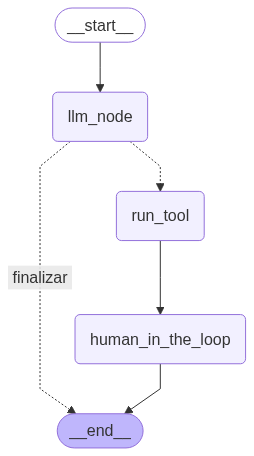

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": uuid.uuid4()}}
input_inicial = {"messages": [{'role': "user", "content": "o que é langgraph?"}]}

for event in graph.stream(input_inicial, config, stream_mode="updates"):
    print(event)
    print("\n")

0----==-=-=-=-=-=-=-==-=-=-=
[HumanMessage(content='o que é langgraph?', additional_kwargs={}, response_metadata={}, id='3d7cc3a1-ad60-4ebd-b5a5-3e84b4efd111')]
{'llm_node': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DNlCA3zQwAVVtN7Kvx9DRn2K', 'function': {'arguments': '{"question":"O que é LangGraph?"}', 'name': 'get_langgraph_response'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 120, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_658b958c37', 'id': 'chatcmpl-Bkgwc3oueQPwcU6dzApKZBgfomleQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--578ac15a-3353-4761-91ee-b072f2924a1e-0', tool_calls=[{'

/usr/local/lib/python3.11/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=0.6, input_type=float])
  return self.__pydantic_serializer__.to_python(


{'run_tool': {'messages': [{'role': 'tool', 'name': 'get_langgraph_response', 'content': '- L\n- a\n- n\n- g\n- G\n- r\n- a\n- p\n- h\n-  \n- é\n-  \n- u\n- m\n-  \n- f\n- r\n- a\n- m\n- e\n- w\n- o\n- r\n- k\n-  \n- d\n- e\n-  \n- o\n- r\n- q\n- u\n- e\n- s\n- t\n- r\n- a\n- ç\n- ã\n- o\n-  \n- d\n- e\n-  \n- b\n- a\n- i\n- x\n- o\n-  \n- n\n- í\n- v\n- e\n- l\n-  \n- p\n- r\n- o\n- j\n- e\n- t\n- a\n- d\n- o\n-  \n- p\n- a\n- r\n- a\n-  \n- c\n- r\n- i\n- a\n- r\n- ,\n-  \n- g\n- e\n- r\n- e\n- n\n- c\n- i\n- a\n- r\n-  \n- e\n-  \n- i\n- m\n- p\n- l\n- e\n- m\n- e\n- n\n- t\n- a\n- r\n-  \n- a\n- g\n- e\n- n\n- t\n- e\n- s\n-  \n- q\n- u\n- e\n-  \n- o\n- p\n- e\n- r\n- a\n- m\n-  \n- e\n- m\n-  \n- l\n- o\n- n\n- g\n- o\n-  \n- p\n- r\n- a\n- z\n- o\n-  \n- e\n-  \n- p\n- o\n- s\n- s\n- u\n- e\n- m\n-  \n- e\n- s\n- t\n- a\n- d\n- o\n-  \n- p\n- e\n- r\n- s\n- i\n- s\n- t\n- e\n- n\n- t\n- e\n- .\n- L\n- a\n- n\n- g\n- G\n- r\n- a\n- p\n- h\n-  \n- o\n- f\n- e\n- r\n- e\n- c\n- e\n

In [ ]:
for event in graph.stream(Command(resume = {"resposta": "y"}), config, stream_mode="updates"):
    print(event)
    print("\n")

0=-=-=-==-=-=-=-=-==
[HumanMessage(content='o que é langgraph?', additional_kwargs={}, response_metadata={}, id='3d7cc3a1-ad60-4ebd-b5a5-3e84b4efd111'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DNlCA3zQwAVVtN7Kvx9DRn2K', 'function': {'arguments': '{"question":"O que é LangGraph?"}', 'name': 'get_langgraph_response'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 120, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_658b958c37', 'id': 'chatcmpl-Bkgwc3oueQPwcU6dzApKZBgfomleQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--578ac15a-3353-4761-91ee-b072f2924a1e-0', tool_calls=[{'name': 'get_langgraph_response', 'a

In [ ]:
config = {"configurable": {"thread_id": uuid.uuid4()}}
input_inicial = {"messages": [{'role': "user", "content": "o que é langsmith?"}]}

for event in graph.stream(input_inicial, config, stream_mode="updates"):
    print(event)
    print("\n")

0----==-=-=-=-=-=-=-==-=-=-=
[HumanMessage(content='o que é langsmith?', additional_kwargs={}, response_metadata={}, id='8389bf79-a73c-4e26-9538-64a5166bf7ee')]
{'llm_node': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M60gLYRFKYpeRab53u0I7ZQx', 'function': {'arguments': '{"question":"O que é LangSmith?"}', 'name': 'get_langgraph_response'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 120, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_658b958c37', 'id': 'chatcmpl-BkgzDR2D7mN2j3VxGo4cApGRUcOhT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--474182fd-cdd9-48bf-96e7-31def2669dba-0', tool_calls=[{'

In [ ]:
for event in graph.stream(Command(resume = {"resposta": "n", "human_data": "reduza o limiar de similaridade para trazer as respostas, coloque em 0.3"}), config, stream_mode="updates"):
    print(event)
    print("\n")

0=-=-=-==-=-=-=-=-==
[HumanMessage(content='o que é langsmith?', additional_kwargs={}, response_metadata={}, id='8389bf79-a73c-4e26-9538-64a5166bf7ee'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M60gLYRFKYpeRab53u0I7ZQx', 'function': {'arguments': '{"question":"O que é LangSmith?"}', 'name': 'get_langgraph_response'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 120, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_658b958c37', 'id': 'chatcmpl-BkgzDR2D7mN2j3VxGo4cApGRUcOhT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--474182fd-cdd9-48bf-96e7-31def2669dba-0', tool_calls=[{'name': 'get_langgraph_response', 'a

In [ ]:
for event in graph.stream(Command(resume = {"resposta": "y", "human_data": "reduza o limiar de similaridade para trazer as respostas, coloque em 0.3"}), config, stream_mode="updates"):
    print(event)
    print("\n")

0=-=-=-==-=-=-=-=-==
[HumanMessage(content='o que é langsmith?', additional_kwargs={}, response_metadata={}, id='8389bf79-a73c-4e26-9538-64a5166bf7ee'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M60gLYRFKYpeRab53u0I7ZQx', 'function': {'arguments': '{"question":"O que é LangSmith?"}', 'name': 'get_langgraph_response'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 120, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_658b958c37', 'id': 'chatcmpl-BkgzDR2D7mN2j3VxGo4cApGRUcOhT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--474182fd-cdd9-48bf-96e7-31def2669dba-0', tool_calls=[{'name': 'get_langgraph_response', 'a